[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/source/image_registration.ipynb)

# Image Registration by Direct Optimization

In this tutorial we are going to learn how to perform the task of image alignment by optimising the similarity transformation between two images in order to create a photo with wide in-focus area from set of narrow-focused images.
The images are courtesy of [Dennis Sakva](https://twitter.com/DennisSakva)

In [ ]:
%%capture
!pip install git+https://github.com/kornia/kornia

In [ ]:
%%capture
!wget http://cmp.felk.cvut.cz/~mishkdmy/bee.zip
!unzip bee.zip

Import needed libraries

In [ ]:
import os
from copy import deepcopy
from typing import List

import cv2
import imageio
import kornia as K
import kornia.geometry as KG
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm


def get_data_directory(base):
    path = os.path.join("../", base)
    if os.path.isdir(os.path.join(path, "data")):
        return os.path.join(path, "data/")
    return get_data_directory(path)


def load_timg(file_name):
    """Loads the image with OpenCV and converts to torch.Tensor"""
    assert os.path.isfile(file_name), f"Invalid file {file_name}"
    # load image with OpenCV
    img = cv2.imread(file_name, cv2.IMREAD_COLOR)
    # convert image to torch tensor
    tensor = K.image_to_tensor(img, None).float() / 255.0
    return K.color.bgr_to_rgb(tensor)

## Images preview

Let's check our images. There are almost 100 of them, so we will show only each 10th

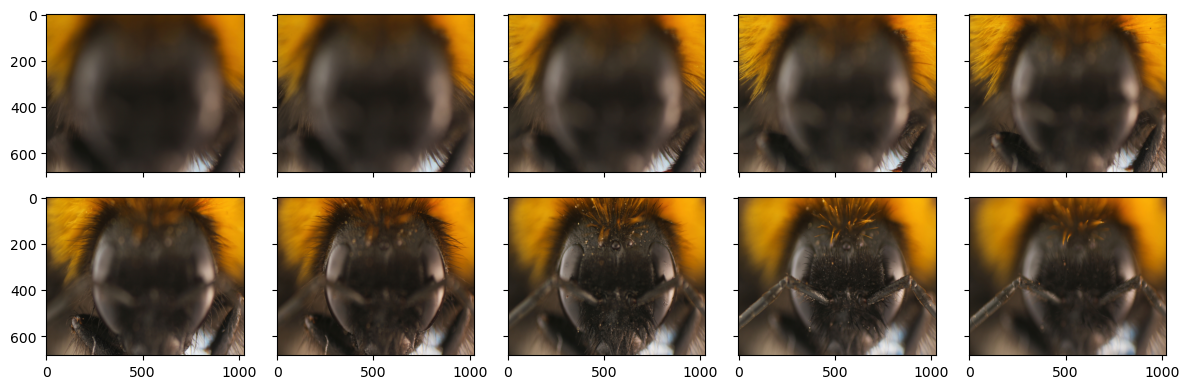

In [ ]:
fnames = os.listdir("bee")
fnames = [f"bee/{x}" for x in sorted(fnames) if x.endswith("JPG")]
fig, axis = plt.subplots(2, 5, figsize=(12, 4), sharex="all", sharey="all", frameon=False)
for i, fname in enumerate(fnames):
    if i % 10 != 0:
        continue
    j = i // 10
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    axis[j // 5][j % 5].imshow(img, aspect="auto")
plt.subplots_adjust(wspace=0.05, hspace=0.05)
fig.tight_layout()

So the focus goes from back to the front, so we have to match and merge them in the same order.

## Image registration

We will need `ImageRegistrator` object to do the matching. Because the photos are takes so that only slight rotation, shift and scale change is possible, we will use `similarity` mode, which does exactly this.

In [ ]:
use_cuda: bool = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
registrator = KG.ImageRegistrator("similarity", loss_fn=F.mse_loss, lr=8e-4, pyramid_levels=3, num_iterations=500).to(device)
print(device)

cuda


We will register images sequentially with `ImageRegistrator`. 

In [ ]:
%%capture
models = []
for i, fname in tqdm(enumerate(fnames)):
    if i == 0:
        continue
    prev_img = load_timg(fnames[i - 1]).to(device)
    curr_img = load_timg(fname).to(device)
    model = registrator.register(prev_img, curr_img)
    models.append(deepcopy(model.detach()))

Let's take the final (the most close-focused) image as the reference - this means that we have to convert our image transforms from (between `i` and `i+1`) mode into (between `i` and last). We can do it by matrix multiplication.

In [ ]:
models_to_final = [torch.eye(3, device=device)[None]]
for m in models[::-1]:
    models_to_final.append(m @ models_to_final[-1])
models_to_final = models_to_final[::-1]

Let's check what do we got. 

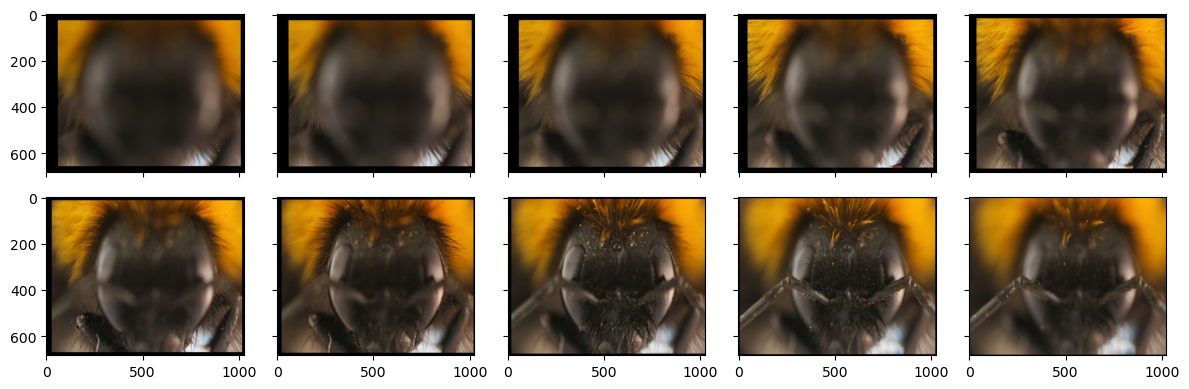

In [ ]:
fig, axis = plt.subplots(2, 5, figsize=(12, 4), sharex="all", sharey="all", frameon=False)
for i, fname in enumerate(fnames):
    if i % 10 != 0:
        continue
    timg = load_timg(fname).to(device)
    j = i // 10
    timg_dst = KG.homography_warp(timg, models_to_final[i], timg.shape[-2:])
    axis[j // 5][j % 5].imshow(K.tensor_to_image(timg_dst * 255.0).astype(np.uint8), aspect="auto")
plt.subplots_adjust(wspace=0.05, hspace=0.05)
fig.tight_layout()

Finally we will merge the image sequence into single image. 
The idea is to detect the image parts, which are in focus from the current image and blend them into the final images.
To get the sharp image part we can use `kornia.filters.laplacian`. 
Then we reproject image1 into image2, and merge them using mask we created.

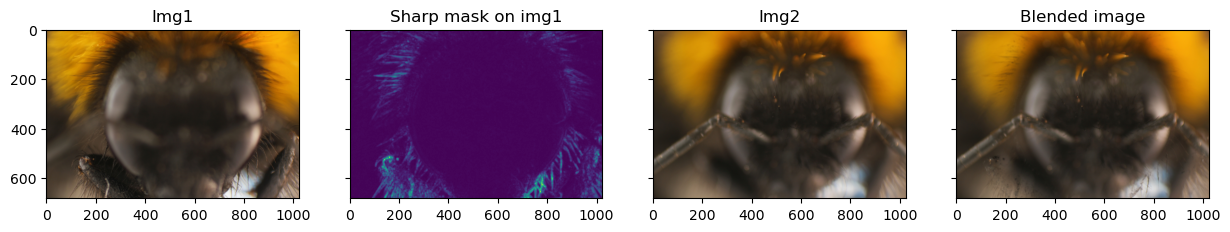

In [ ]:
def merge_sharp1_into2(timg1, timg2, trans1to2, verbose=False):
    curr_img = timg2.clone()
    warped = KG.homography_warp(timg1, torch.inverse(trans1to2), timg.shape[-2:])
    mask1 = K.filters.laplacian(K.color.rgb_to_grayscale(timg1), 7).abs()
    mask1_norm = (mask1 - mask1.min()) / (mask1.max() - mask1.min())
    mask1_blur = K.filters.gaussian_blur2d(mask1_norm, (9, 9), (1.6, 1.6))
    mask1_blur = mask1_blur / mask1_blur.max()
    warped_mask = KG.homography_warp(mask1_blur.float(), torch.inverse(models_to_final[i]), timg1.shape[-2:])
    curr_img = warped_mask * warped + (1 - warped_mask) * curr_img
    if verbose:
        fig, axis = plt.subplots(1, 4, figsize=(15, 6), sharex="all", sharey="all", frameon=False)
        axis[0].imshow(K.tensor_to_image(timg1))
        axis[1].imshow(K.tensor_to_image(mask1_blur))
        axis[2].imshow(K.tensor_to_image(timg2))
        axis[3].imshow(K.tensor_to_image(curr_img))
        axis[0].set_title("Img1")
        axis[1].set_title("Sharp mask on img1")
        axis[2].set_title("Img2")
        axis[3].set_title("Blended image")
    return curr_img


timg1 = load_timg(fnames[50]).to(device)
timg2 = load_timg(fnames[-1]).to(device)
out = merge_sharp1_into2(timg1, timg2, models_to_final[50], True)

The blending does not look really good, but that is because we are trying to merge non-consequtive images with very different focus. Let's try to apply it sequentially and see, what happens.

We will also create a video of our sharpening process.

In [ ]:
%%capture
base_img = load_timg(fnames[-1])
curr_img = deepcopy(base_img)
try:
    video_writer = imageio.get_writer("sharpening.avi", fps=8)
    video_writer.append_data((K.tensor_to_image(curr_img) * 255.0).astype(np.uint8))
    video_ok = True
except:
    video_ok = False


with torch.no_grad():
    for i, fname in tqdm(enumerate(fnames)):
        timg = load_timg(fname)
        curr_img = merge_sharp1_into2(timg.to(device), curr_img.to(device), models_to_final[i].to(device))
        if video_ok:
            video_writer.append_data((K.tensor_to_image(curr_img) * 255.0).astype(np.uint8))
if video_ok:
    video_writer.close()

Text(0.5, 1.0, 'Final result')

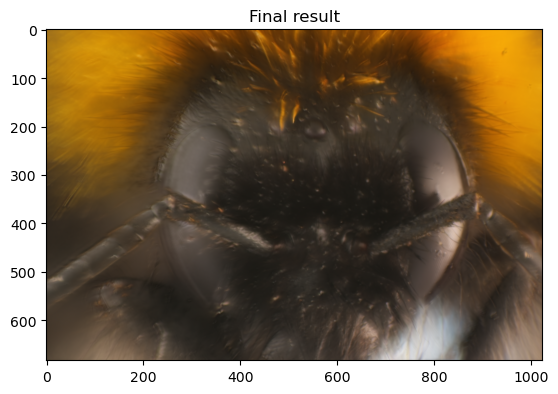

In [ ]:
plt.imshow(K.tensor_to_image(curr_img.float()))
plt.title("Final result")

Now we can play the video of our sharpening. The code is ugly to allow running from Google Colab (as shown [here](https://code.luasoftware.com/tutorials/jupyter/google-colab-play-video/))


In [ ]:
from base64 import b64encode

from IPython.display import HTML

if video_ok:
    mp4 = open("sharpening.avi", "rb").read()
else:
    mp4 = open(get_data_directory("") + "sharpening.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()


HTML(
    f"""
<video width=400 controls>
      <source src="{data_url}" type="video/mp4">
</video>
"""
)

Result looks quite nice and more detailed, although a bit soft. You can try yourself different blending parameters yourself (e.g. blur kernel size) in order to improve the final result.